# PyTie
#### *Seismic-well tie in Python*
------------
This package reads .LAS files and returns at the end a time-depth table. By calculating your time-depth table with PyTie you can be in control of each step necessary to create the table necessary for having a seismic-well tie to be imported in interpretation softwares.

## Importing the functions

In [1]:
import pytie.functions as pytie
from IPython.display import Image
import matplotlib.pyplot as plt
import lasio

## Importing the data (.LAS file)

Here you can add one or more files. Each one has to be separated by comas and within quotation marks.

In [2]:
#las_files = ('dados/1RJS_0051__RJ_1RJS_0051__RJ_BHC_00003.las', 'dados/1RJS_0051__RJ_1RJS_0051__RJ_FDC_CNL_00001.las', '1RJS_0051__RJ_1RJS_0051__RJ_FDC_CNL_GR_00004.las', '1RJS_0051__RJ_1RJS_0051__RJ_IES_00005.las', '1RJS_0051__RJ_1RJS_0051__RJ_ISF_BHC_GR_00002.las', '1RJS_0051__RJ_1RJS_0051__RJ_SIGEO__013_00006.las')

In [3]:
las_files = ('dados/Walapka1.las')

Specify the number of files imported:

In [4]:
N_files = 1

## Importing the logs DT and RHOB plus the depth index

If you have more than one file for each well or if your header has too much information it is necessary to open each of the .LAS files in a text editor and add to the DT "curve information" after the colon signal the name (Sonic) and add (Bulk density) to the RHOB curve (after the colon!). Otherwise the code will not be able to find the data due to the possibility of picking other item instead of the DT field. You also need to check how the depth data is being named. In the file given as example the depth is being named M__DEPTH. See the image bellow. You will update the following code with the names found in the file.

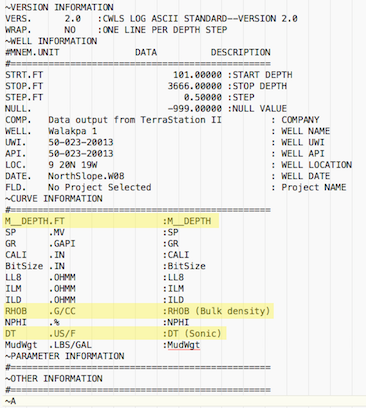

In [5]:
Image("images/header.png")

In [6]:
DT_id = 'DT'          
RHOB_id = 'RHOB'
Depth_id = 'M__DEPTH'

## PyTie function: int_data

This function reads the .LAS files and integrates logs if they are divided in different files or columns returning the DT, RHOB and the DEPTH data in separate parameters.

In [7]:
DT, RHOB = pytie.int_data(las_files, N_files, DT_id, RHOB_id, Depth_id)

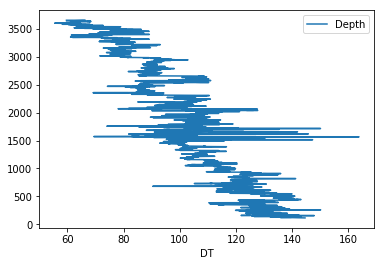

In [8]:
DT.plot(x='DT', y='Depth')

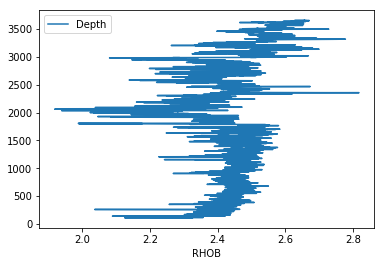

In [9]:
RHOB.plot(x='RHOB', y='Depth')

## PyTie function: fill_gaps

Fills gaps in the Depth index atributing null values to DT and/or RHOB. 

In [10]:
DT, RHOB = pytie.fill_gaps(DT, RHOB)

User: DT and RHOB have already the same number of samples. This operation is not necessary.


TypeError: 'NoneType' object is not iterable

## PyTie function: fill_log

Fills the begining and the end of the logs with null values to complete the absence of valid data.

In [11]:
DEPTH, DT, RHOB = pytie.fill_log(N_files, las_files, DT,RHOB)

## PyTie function: rhob_fill_gardner

This function is based on the Gardner's equation as shown below:

$ \rho = \alpha V_p^{\beta}$  

where, $\rho$ is the density and its unit is in $g/cc$, $V_p$ is the velocity of the P wave in ft/s, $\alpha = 0.23$, $beta = 0.25$ - empirically derived constants that depend on the geology. In a future version you will be able to adjust these two parameters manually.

In [12]:
#parameters values - they can change with geology. Standard values: alfa = 0.23 and beta = 0.25:
alfa = 0.25
beta = 0.25

In [13]:
RHOB_fill = pytie.rhob_fill_gardner(RHOB, DT, alfa, beta)

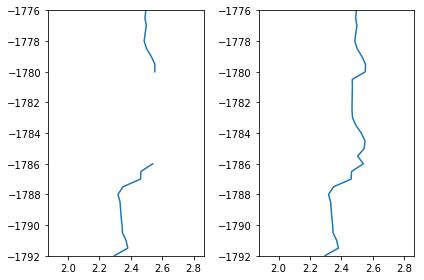

In [14]:
plt.subplot(1, 2, 1)
plt.plot(RHOB,-DEPTH)
plt.ylim((-1792,-1776))

plt.subplot(1, 2, 2)
plt.plot(RHOB_fill,-DEPTH)
plt.ylim((-1792,-1776))

plt.tight_layout()

## PyTie function: DT_fill_gardner

This function is based on the inverse Gardner's equation, as shown below.

$ V_p = \gamma \rho ^4$  

where, $V_p$ is in ft/s, $\gamma$ is an experimental parameter that changes with geology (standard value = 357) and $\rho$ in $g/cc$.

In [15]:
gamma = 300

In [16]:
DT_fill = pytie.DT_fill_gardner(RHOB,DT, gamma)

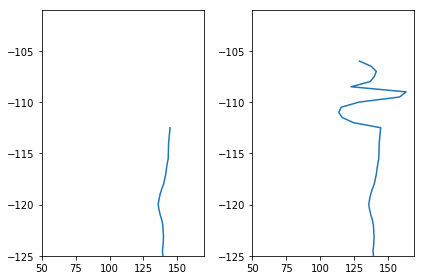

In [17]:
plt.subplot(1, 2, 1)
plt.plot(DT,-DEPTH)
plt.ylim((-125,-101))

plt.subplot(1, 2, 2)
plt.plot(DT_fill,-DEPTH)
plt.ylim((-125,-101))

plt.tight_layout()

### PyTie function: delete_NAN

This step is necessary if you plan to apply machine learning algorithms to your data.

In [18]:
DEPTH, DT, RHOB = pytie.delete_NaN(DEPTH, DT_fill, RHOB_fill)

### Estimating velocities for the sea water and the sea floor

The physical properties of the sea water are very sensitive to temperature, salinity and pressure as you can see in the images bellow:

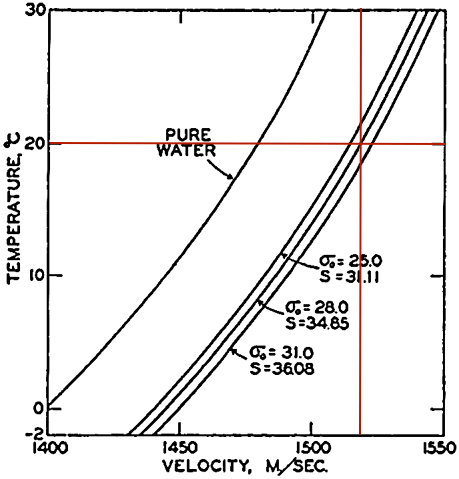

In [19]:
Image("images/grafico_mar.png", width=250)

*Image: Velocity of sound in pure water and in sea water at atmospheric pressure as a function of temperature and salinity (Matthews, 1927).*

According to the graph, in the Campos Basin the velocity of the sea water at the surface is around 1515 m/s, if the temperature of the sea water of $20^{\circ}C$ and the salinity of 34.85 are taken as average.

If the sea bottom is deep the pressure will also change the velocity of the water, as you can see in the figure below:

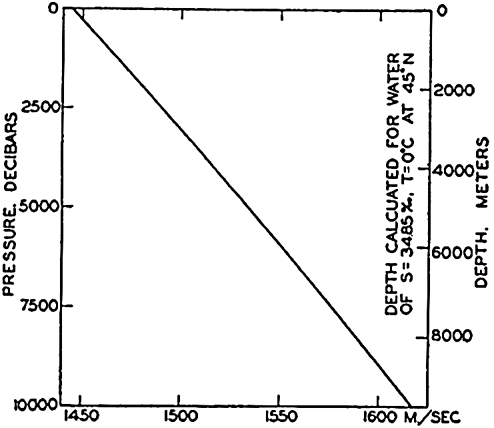

In [20]:
Image("images/grafico_mar_pressao.png", width=300)

*Image: Osmotic pressure, vapor pressure relative to that of pure water, freezing point, and temperature of maximum density as functions of chlorinity and salinity (Thompson, 1932).*

The prediction of the water velocity depends on three variables, so it's not so simple to do it. To simplify, I will fix two of the variables - salinity and water temperature at surface - in 34.85 and $ 20^\circ$C, respectively. For my purpose, to work with data from the Campos basin, it is enough. But, if you need changes, please, ask me how to do it. For now, I'm opting for this simplification.

## PyTie function: sea_water_vel

In [21]:
sea_bottom_depth = 250  # meters

In [22]:
vel_predict = pytie.sea_water_vel(sea_bottom_depth)
vel_predict

1521.6859

## Estimating de velocity and density of the soil/rocks near the surface/sea bottom

Verify in your well composite what is the lithology at the sea bottom or at the surface, if it is available, and check at the table the corresponding density. The velocity will be estimated by Gardner's inverse equation.

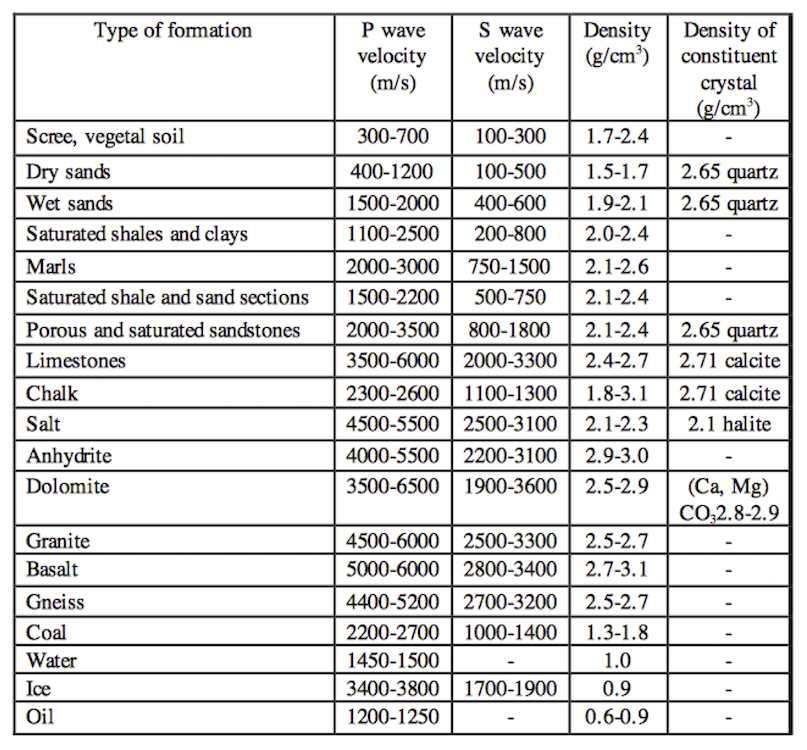

In [23]:
Image("images/abaco.png", width=600)

*Source: Bourbié, Coussy, and Zinszner, Acoustics of Porous Media, Gulf Publishing.*

In [24]:
d_sediment =  2.0   # in g/cc

In [25]:
V_sed = (378*((d_sediment)**4))*0.3048  
V_sed

1843.4304000000002

## Estimating velocities between the seafloor/surface and the first log register

Two models were tested with the compilation of all data to predict values between the sea water and the sea floor. The first image shows the fitting line in blue of a linear regression. The second image the fitting curve of a polynomial regression. It can be concluded that the linear regression will not be able to predict correctly values between the sea floor/surface and the first register because the DT data will be underestimated in that area (see the detailed image bellow). The polynomial fitting was not able either to predict de area between the seafloor/surface and the first register because the end of the curve don't reach the first given depths. The solution, proposed here is to connect the sea water velocity and the first register with a straight line.

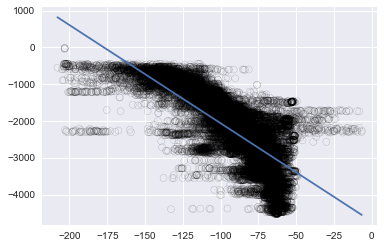

In [26]:
Image("images/linear_regression.png", width=300)

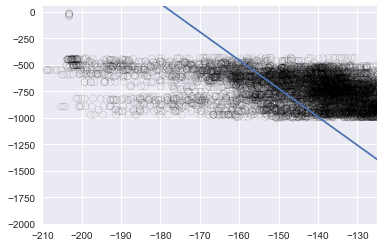

In [27]:
Image("images/linear_regression_d.png", width=300)

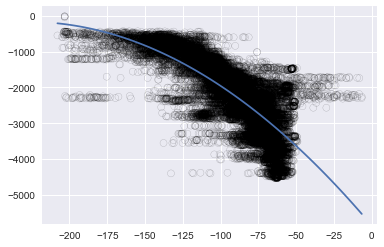

In [28]:
Image("images/polynomial_regression.png", width=300)

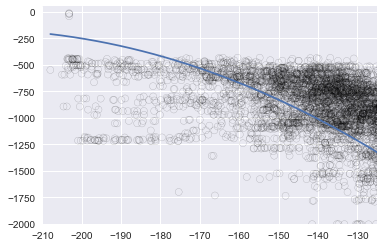

In [29]:
Image("images/polynomial_regression_d.png", width=300)

### Creating a straight line between the sea bottom (or surface) and the average of the firsts 10 registers

It is important to estimate the densities and velocities of the whole sedimentary column in order to simulate the same result seen is a seismic section. 

Extracting the samples step from the .LAS file:

In [30]:
if N_files == 1:
    log0 = lasio.read(las_files)
else:
    log0 = lasio.read(las_files[0])
    
STEP = log0.well.STEP.value

Extracting the value of the seafloor/surface from the .LAS file:

In [31]:
ground_level = log0.well.EGL.value  # change here the acronym that you find in you file or attribute a value
ground_level

10.0

If the code above didn't work for you, it's possible to attribute a value manually:

In [32]:
# Delete the first comment symbol (#) from the code below:

#ground_level = -5  # negative values indicate submarine wells.

Attribute a depth for the source of seismic waves:

In [33]:
depth_source = 5.

In [34]:
DEPTH, DT, RHOB = pytie.ext_line(d_sediment, depth_source, ground_level, DEPTH, DT, RHOB, STEP)

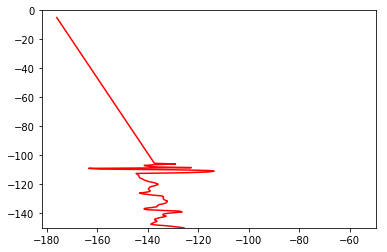

In [35]:
plt.plot(-DT, -DEPTH, '-', color='red')
plt.ylim(-150,0)
plt.show()

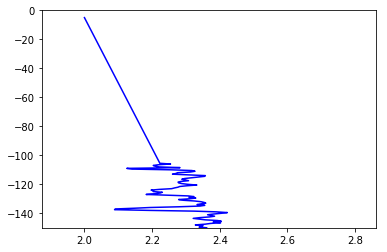

In [36]:
plt.plot(RHOB, -DEPTH, '-', color='blue')
plt.ylim(-150,0)
plt.show()

## Filtering the logs to delete spikes

Alert!! The excessive filtering reduces the impedance contrast which, consequently, creates a synthetic seismogram smoothed. The window size has to be an odd number greater than 3. 

In [37]:
data1 = DT
window_size = 15.

In [38]:
data2 = RHOB
window_size = 15.

In [39]:
DEPTH_fil, DT_fil = pytie.moving_average(data1, window_size, DEPTH)

In [40]:
DEPTH_fil, RHOB_fil = pytie.moving_average(data2, window_size, DEPTH)

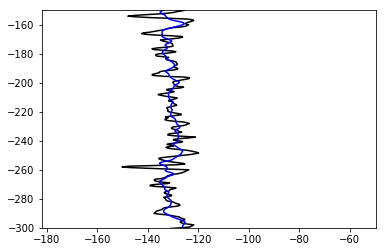

In [41]:
plt.plot(-DT, -DEPTH, '-', color='black')
plt.plot(-DT_fil, -DEPTH_fil, '-', color='blue')
plt.ylim(-300,-150)
plt.show()

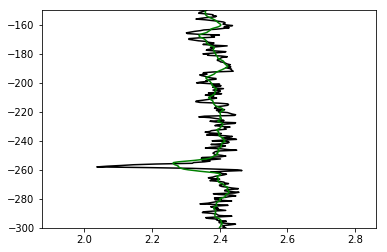

In [42]:
plt.plot(RHOB, -DEPTH, '-', color='black')
plt.plot(RHOB_fil, -DEPTH_fil, '-', color='green')
plt.ylim(-300,-150)
plt.show()

If the result is satisfatory, assign the new values to the parameters:

In [43]:
DT = DT_fil
RHOB = RHOB_fil
DEPTH = DEPTH_fil

## Adding geological/geophysical markers

In [44]:
markers = ('Surficial Deposits and/or Gubik Formation','Torok Formation','Pebble Shale Unit','Kingak Shale','Sag River Sandstone', 'Shublik Formation','Basement Complex')

In [45]:
depths_markers = (19, 50,1700,2090,3220,3260,3630)

## Calculating the acoustic impedance

The acoustic impedance is the product of density and velocity of each sample.

In [46]:
I = pytie.impedance(DT,RHOB)

## Calculating the reflection coefficients

The reflexion coefficients are an adimensional parameter. Because of this it's not necessary to be worried about units. The coefficients can be found by the following formula:

$R_{coef} = \dfrac{I_2 - I_1}{I_2 + I_1}$

Where: $I$ = Acoustic Impedance

In [47]:
R_coef = pytie.r_coef(I)

##  Creating a synthetic seismogram

Inputs for the ricker pulse:

In [48]:
f = 20
length=0.512
dt=0.0004

In [49]:
seismogram = pytie.syn_seis(R_coef, f, length, dt)

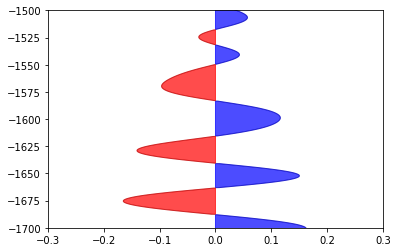

In [50]:
plt.plot(seismogram, -DEPTH[1:], lw=1, color='black', alpha=0.2) 
plt.fill_betweenx(-DEPTH[1:], seismogram, 0., seismogram > 0., interpolate=False, color='blue', alpha = 0.7)
plt.fill_betweenx(-DEPTH[1:], seismogram, 0., seismogram < 0., interpolate=False, color='red', alpha = 0.7)
plt.ylim (-1700,-1500)
plt.xlim(-0.3,0.3)
plt.show()   

## Plotting the result

In [51]:
title = "Seismic-well tie for the well Walakpa 1"

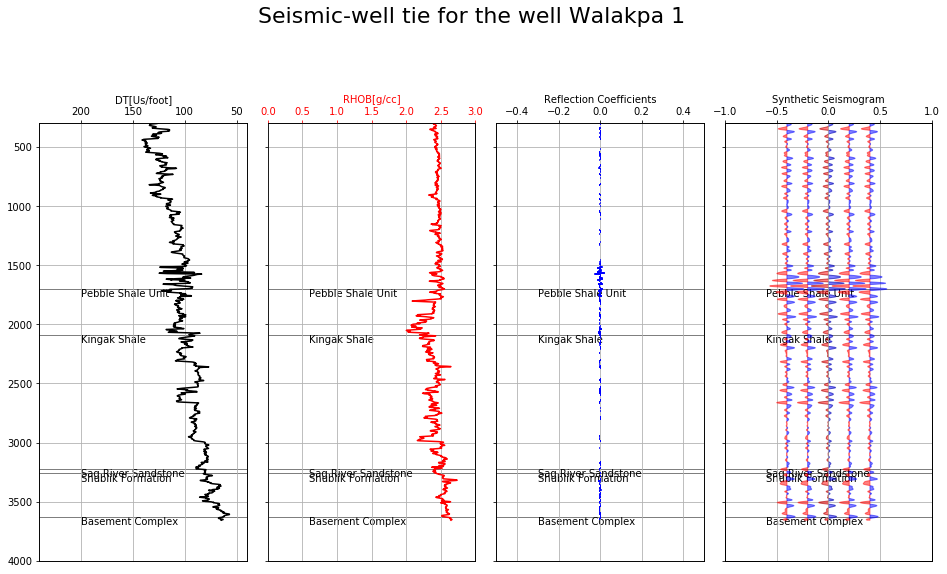

In [52]:
pytie.combo_plot1(300,4000, title, depths_markers, markers, RHOB, DEPTH, DT, R_coef, seismogram)

# Image Cosmetics

The functions bellow don't impact in the calculus of the time-depth table. Because of it they are called image cosmetic functions. Their goal is to improve the visualization of seismic reflectors. Here they are used to make the synthetic seismogram more similar to the seismic section.

## Adding gain to compensate the absorption phenomenon

Adjust the magnitude of the gain:

In [53]:
mag = 1

Stipulate the initial depth of the gain function:

In [54]:
initial_depth = 0

In [55]:
gain, seismogram2 = pytie.gain(mag, initial_depth, DEPTH, R_coef,length, dt, f)

In [56]:
title ='Comparison between synthetic seismograms and the seismic'

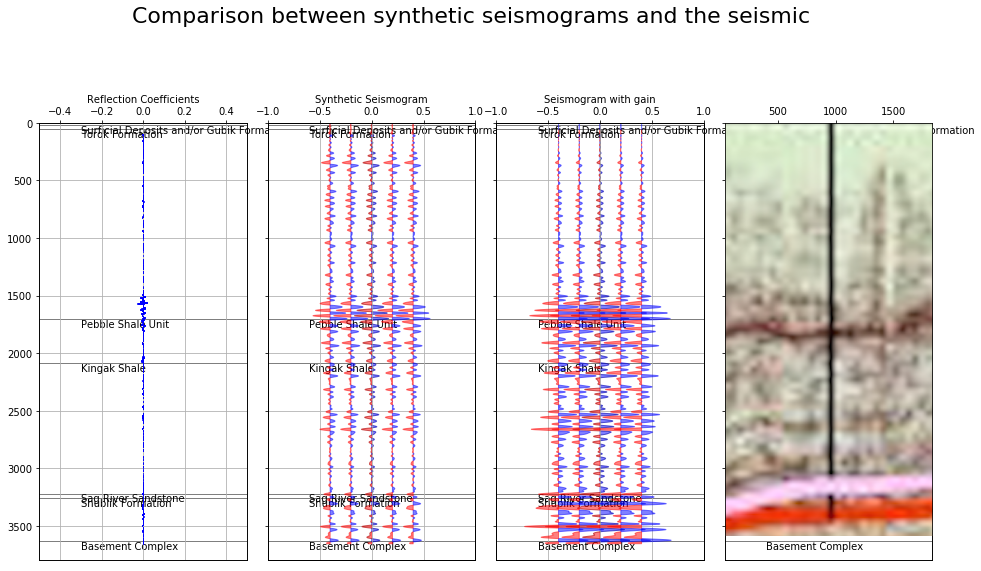

In [57]:
pytie.combo_plot2(0,3800, title, depths_markers, markers, RHOB, DEPTH, DT, R_coef, seismogram, seismogram2, img_adr = 'images/seismic_wala1.png')

## Loss of frequency with depth due to attenuation

In [58]:
depth_change = 1450

In [59]:
seism_freq = pytie.freq_corr(f, depth_change, DEPTH, length, dt, gain)

In [60]:
title = 'Comparison between the original seismogram and the application of image cosmetics functions'

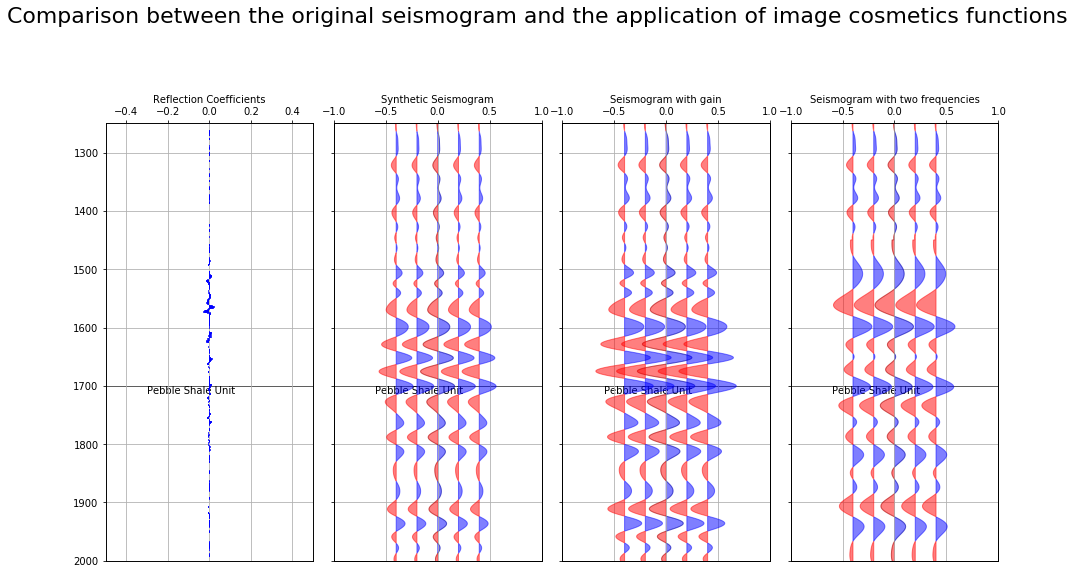

In [61]:
pytie.combo_plot3(1250,2000, title, depths_markers, markers, RHOB, DEPTH, DT, R_coef, seismogram, seismogram2, seism_freq)

## Time-depth conversion 

Finally, the time-depth table. 

In [62]:
time_depth_table = pytie.time_depth(N_files, las_files, DT, DEPTH, depth_source) 
time_depth_table.tail()

,Depth (m),Time (ms)
7292,3654.5,2483.513339
7293,3655.0,2483.726382
7294,3655.5,2483.940073
7295,3656.0,2484.154211
7296,3656.5,2484.367434


## Exporting the table

In [ ]:
well_name = str(log0.well.well.value)
well_name

In [ ]:
time_depth_table.to_csv(well_name+'_Time_Depth.csv', encoding='utf-8', index=False)